In [1]:
import torch
import torch.nn as nn
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data_loader import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models import train_model, CombinedLoss
from models.advanced_autoencoders import AutoEncoder
from torch.optim import Adam
from tqdm import tqdm

# Data Loading

Config initialisation

In [2]:
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

In [3]:
data = reader.read_parquet(FILE_KEY_S3)
data.head()

date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_43,…,feature_49,feature_51,feature_52,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
i16,i16,i8,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,34,1,3.889038,1.509601,0.885045,2.831856,-1.201967,11,7,76,-0.271028,0.695742,0.794157,-0.038239,0.045858,0.030772,-0.900359,-0.382682,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.586801,0.250828,0.294883,0.521403,-0.682683,-0.239552,-0.460341,1.955693,1.485422,-0.253407,…,1.380354,1.116463,1.92235,0.375684,-1.258121,-0.705236,0.748627,0.643394,0.627821,1.411739,-1.36224,0.414762,0.683652,0.896076,-1.06081,-0.636584,-0.423285,0.055839,0.424335,-0.108809,1.035421,1.629745,-0.407497,-0.345388,-0.342097,-0.281208,-0.406524,-0.258637,0.573992,-0.319932,-0.335376,-0.21128,-0.279558,-0.434355,-1.220439,0.214211,-0.257941
0,35,1,3.889038,1.636899,1.224167,2.786362,-1.050494,11,7,76,-0.310024,0.05155,0.600186,-0.054901,-0.167249,-0.014244,-0.885459,-0.254649,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.189785,0.945696,1.106982,0.392782,-0.657124,-0.220858,-0.466647,0.24926,0.994481,0.17161,…,1.066112,-1.037891,1.715097,0.067716,-0.876391,0.051228,0.806862,0.703435,0.148378,1.411131,-1.36224,0.41464,0.768911,0.571721,-1.158224,-0.932629,-0.209845,-0.144411,0.304465,-0.11591,0.342235,1.448319,-0.333611,-0.407654,-0.205946,-0.170852,-0.350776,-0.286903,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239
0,36,1,3.889038,1.751107,-0.195755,2.280836,-1.308689,11,7,76,-0.292135,-0.202836,0.615877,-0.075484,-0.318359,-0.049205,-0.930674,-0.666436,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.15204,0.121289,0.794614,0.664937,-0.615451,-0.169856,-0.365646,0.076389,1.351177,0.60942,…,1.095427,-1.714377,1.889433,-0.257992,-1.178176,-0.281169,1.45806,0.599523,-0.062305,1.499916,-1.36224,0.401396,0.701324,0.793441,-0.810332,-0.421096,-0.424012,-0.189834,0.255931,-0.067103,-0.06556,1.456399,-0.405195,-0.351057,-0.189416,-0.220496,-0.373879,-0.340003,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819
0,37,1,3.889038,1.869932,-1.48951,1.470981,-1.040105,11,7,76,-0.34881,-0.476177,0.599473,-0.064814,-0.145902,-0.037824,-0.917428,-0.682684,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.723722,0.289863,0.752283,0.108357,-0.439932,-0.221922,-0.311707,0.186232,1.29547,0.394812,…,0.979125,1.078464,0.791492,-0.55243,-1.282962,0.223554,1.172299,0.73975,-0.584127,1.038086,-1.36224,0.627579,0.601162,0.763969,-0.77326,-0.32353,-0.36246,-0.326542,0.226188,-0.114877,-0.216078,1.169394,-0.405249,-0.399258,-0.282878,-0.236362,-0.322532,-0.284416,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722
0,38,1,3.889038,1.653586,-1.510579,1.045217,-1.045805,11,7,76,-0.359463,-0.173339,0.599964,-0.082462,-0.182317,-0.046782,-0.532617,-0.188155,0.91013,1.636431,1.522133,-1.551398,-0.229627,1.378301,-0.283712,0.123196,0.52142,0.685667,0.240129,0.750362,-0.025711,-0.1079

Ensure sorted by time_id to create batches not leaked

In [4]:
data = data.sort(by="time_id")

Define features and target

In [5]:
target = "responder_6"
features = [col for col in data.columns if "feature" in col]

X, y = data[features], data[target]

Split data

In [6]:
n = X.height
n_train = int(0.8 * n)
X_train = X.slice(0, n_train)
y_train = y.slice(0, n_train)

X_val = X.slice(n_train)
y_val = y.slice(n_train)

Data Wraper

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        y = torch.tensor(y.to_numpy(), dtype=torch.float32)
        if y.ndim == 1:
            y = y.view(-1, 1)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [9]:
train_data_loader = DataLoader(
    train_dataset, batch_size=2048, shuffle=False, num_workers=8
)
val_data_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=8)

In [19]:
lr = 1e-3
device = torch.device("cuda")
alpha = 1.0
beta = 1.0
n_epochs = 100

n_feat = len(features)
architectures_var_latent = {
    # ----------------------------------------------------------------------
    "Archi_A_L8_Profonde": {
        "description": "Forte compression (n_latent=8) + architecture profonde.",
        "n_latent": 8,
        # Les tailles de couches sont conservées de l'Archi 1, seule n_latent change le nombre de paramètres
        "encoder_hidden": [128, 64, 32, 16],
        "decoder_hidden": [16, 32, 64, 128],
        "head_hidden": [4, 2] # Le head est adapté à une entrée plus petite
    },
    # ----------------------------------------------------------------------
    "Archi_B_L32_Large": {
        "description": "Faible compression (n_latent=32) + architecture large.",
        "n_latent": 32,
        # Les tailles de couches sont conservées de l'Archi 2
        "encoder_hidden": [160, 96, 64],
        "decoder_hidden": [64, 96, 160],
        "head_hidden": [32, 16] # Le head est adapté à une entrée plus grande
    },
    # ----------------------------------------------------------------------
    "Archi_C_L24_Hybride": {
        "description": "Compression modérée (n_latent=24) + architecture hybride (profonde et large).",
        "n_latent": 24,
        # Les tailles de couches sont conservées de l'Archi 3
        "encoder_hidden": [256, 128, 64, 32],
        "decoder_hidden": [32, 64, 128, 256],
        "head_hidden": [24, 12, 6] # Le head est adapté à une entrée modérée
    }
}

# Test 

--- Lancement des entraînements par architecture et dimension latente ---

 Entraînement de l'architecture : Archi_A_L8_Profonde (n_latent=8)


  1%|          | 1/100 [00:13<21:44, 13.18s/it]

Epoch 01 | loss=22113.312 | R2_rec_train=-34.1225 | R2_rec_val=0.1153 | R2_sup_train=-0.0041 | R2_sup_val=-0.0030


  2%|▏         | 2/100 [00:26<21:31, 13.18s/it]

Epoch 02 | loss=547.287 | R2_rec_train=0.1682 | R2_rec_val=0.3105 | R2_sup_train=-0.0002 | R2_sup_val=-0.0038


  3%|▎         | 3/100 [00:39<20:58, 12.97s/it]

Epoch 03 | loss=438.058 | R2_rec_train=0.4122 | R2_rec_val=0.4270 | R2_sup_train=0.0001 | R2_sup_val=-0.0041


  4%|▍         | 4/100 [00:52<20:46, 12.98s/it]

Epoch 04 | loss=415.601 | R2_rec_train=0.4745 | R2_rec_val=0.4763 | R2_sup_train=0.0002 | R2_sup_val=-0.0032


  5%|▌         | 5/100 [01:04<20:27, 12.92s/it]

Epoch 05 | loss=400.568 | R2_rec_train=0.5176 | R2_rec_val=0.5218 | R2_sup_train=0.0002 | R2_sup_val=-0.0034


  6%|▌         | 6/100 [01:17<19:55, 12.71s/it]

Epoch 06 | loss=389.339 | R2_rec_train=0.5496 | R2_rec_val=0.5469 | R2_sup_train=0.0002 | R2_sup_val=-0.0035


  7%|▋         | 7/100 [01:27<18:14, 11.76s/it]

Epoch 07 | loss=383.719 | R2_rec_train=0.5655 | R2_rec_val=0.5565 | R2_sup_train=0.0002 | R2_sup_val=-0.0036


  8%|▊         | 8/100 [01:36<16:41, 10.89s/it]

Epoch 08 | loss=380.217 | R2_rec_train=0.5753 | R2_rec_val=0.5678 | R2_sup_train=0.0003 | R2_sup_val=-0.0034


  9%|▉         | 9/100 [01:44<15:34, 10.27s/it]

Epoch 09 | loss=376.977 | R2_rec_train=0.5845 | R2_rec_val=0.5733 | R2_sup_train=0.0004 | R2_sup_val=-0.0031


 10%|█         | 10/100 [01:54<14:54,  9.94s/it]

Epoch 10 | loss=372.825 | R2_rec_train=0.5960 | R2_rec_val=0.5788 | R2_sup_train=0.0004 | R2_sup_val=-0.0032


 11%|█         | 11/100 [02:08<16:36, 11.19s/it]

Epoch 11 | loss=368.812 | R2_rec_train=0.6064 | R2_rec_val=0.5948 | R2_sup_train=0.0006 | R2_sup_val=-0.0031


 12%|█▏        | 12/100 [02:20<16:58, 11.57s/it]

Epoch 12 | loss=365.884 | R2_rec_train=0.6136 | R2_rec_val=0.5994 | R2_sup_train=0.0005 | R2_sup_val=-0.0028


 13%|█▎        | 13/100 [02:32<16:54, 11.66s/it]

Epoch 13 | loss=363.689 | R2_rec_train=0.6193 | R2_rec_val=0.6081 | R2_sup_train=0.0007 | R2_sup_val=-0.0025


 14%|█▍        | 14/100 [02:44<16:59, 11.85s/it]

Epoch 14 | loss=361.900 | R2_rec_train=0.6245 | R2_rec_val=0.6123 | R2_sup_train=0.0007 | R2_sup_val=-0.0020


 15%|█▌        | 15/100 [02:58<17:25, 12.30s/it]

Epoch 15 | loss=360.280 | R2_rec_train=0.6289 | R2_rec_val=0.6175 | R2_sup_train=0.0006 | R2_sup_val=-0.0019


 16%|█▌        | 16/100 [03:11<17:37, 12.59s/it]

Epoch 16 | loss=358.915 | R2_rec_train=0.6326 | R2_rec_val=0.6170 | R2_sup_train=0.0007 | R2_sup_val=-0.0028


 17%|█▋        | 17/100 [03:23<17:10, 12.41s/it]

Epoch 17 | loss=357.757 | R2_rec_train=0.6355 | R2_rec_val=0.6165 | R2_sup_train=0.0010 | R2_sup_val=-0.0022


 18%|█▊        | 18/100 [03:33<16:03, 11.75s/it]

Epoch 18 | loss=356.479 | R2_rec_train=0.6380 | R2_rec_val=0.6206 | R2_sup_train=0.0018 | R2_sup_val=-0.0032


 19%|█▉        | 19/100 [03:46<16:21, 12.12s/it]

Epoch 19 | loss=355.381 | R2_rec_train=0.6404 | R2_rec_val=0.6284 | R2_sup_train=0.0024 | R2_sup_val=-0.0031


 20%|██        | 20/100 [03:57<15:43, 11.79s/it]

Epoch 20 | loss=353.933 | R2_rec_train=0.6440 | R2_rec_val=0.6285 | R2_sup_train=0.0025 | R2_sup_val=-0.0025


 21%|██        | 21/100 [04:08<15:21, 11.67s/it]

Epoch 21 | loss=351.828 | R2_rec_train=0.6484 | R2_rec_val=0.6344 | R2_sup_train=0.0034 | R2_sup_val=-0.0015


 22%|██▏       | 22/100 [04:21<15:40, 12.05s/it]

Epoch 22 | loss=350.761 | R2_rec_train=0.6515 | R2_rec_val=0.6362 | R2_sup_train=0.0031 | R2_sup_val=-0.0012


 23%|██▎       | 23/100 [04:32<14:59, 11.68s/it]

Epoch 23 | loss=349.845 | R2_rec_train=0.6538 | R2_rec_val=0.6383 | R2_sup_train=0.0034 | R2_sup_val=-0.0012


 24%|██▍       | 24/100 [04:42<14:13, 11.23s/it]

Epoch 24 | loss=349.077 | R2_rec_train=0.6558 | R2_rec_val=0.6441 | R2_sup_train=0.0037 | R2_sup_val=-0.0010


 25%|██▌       | 25/100 [04:54<14:11, 11.36s/it]

Epoch 25 | loss=348.458 | R2_rec_train=0.6576 | R2_rec_val=0.6391 | R2_sup_train=0.0032 | R2_sup_val=-0.0017


 26%|██▌       | 26/100 [05:07<14:40, 11.90s/it]

Epoch 26 | loss=347.615 | R2_rec_train=0.6597 | R2_rec_val=0.6475 | R2_sup_train=0.0035 | R2_sup_val=-0.0008


 27%|██▋       | 27/100 [05:19<14:33, 11.97s/it]

Epoch 27 | loss=347.036 | R2_rec_train=0.6612 | R2_rec_val=0.6456 | R2_sup_train=0.0039 | R2_sup_val=-0.0004


 28%|██▊       | 28/100 [05:31<14:11, 11.83s/it]

Epoch 28 | loss=346.822 | R2_rec_train=0.6621 | R2_rec_val=0.6460 | R2_sup_train=0.0036 | R2_sup_val=-0.0011


 29%|██▉       | 29/100 [05:43<14:03, 11.87s/it]

Epoch 29 | loss=346.185 | R2_rec_train=0.6636 | R2_rec_val=0.6506 | R2_sup_train=0.0039 | R2_sup_val=-0.0009


 30%|███       | 30/100 [05:55<13:47, 11.82s/it]

Epoch 30 | loss=345.718 | R2_rec_train=0.6651 | R2_rec_val=0.6518 | R2_sup_train=0.0036 | R2_sup_val=-0.0004


 31%|███       | 31/100 [06:06<13:32, 11.77s/it]

Epoch 31 | loss=345.333 | R2_rec_train=0.6662 | R2_rec_val=0.6490 | R2_sup_train=0.0036 | R2_sup_val=-0.0009


 32%|███▏      | 32/100 [06:19<13:42, 12.09s/it]

Epoch 32 | loss=344.842 | R2_rec_train=0.6672 | R2_rec_val=0.6496 | R2_sup_train=0.0044 | R2_sup_val=-0.0001


 33%|███▎      | 33/100 [06:31<13:33, 12.14s/it]

Epoch 33 | loss=344.533 | R2_rec_train=0.6683 | R2_rec_val=0.6469 | R2_sup_train=0.0042 | R2_sup_val=-0.0005


 34%|███▍      | 34/100 [06:42<12:58, 11.79s/it]

Epoch 34 | loss=344.104 | R2_rec_train=0.6695 | R2_rec_val=0.6464 | R2_sup_train=0.0044 | R2_sup_val=-0.0004


 35%|███▌      | 35/100 [06:53<12:21, 11.40s/it]

Epoch 35 | loss=343.822 | R2_rec_train=0.6699 | R2_rec_val=0.6437 | R2_sup_train=0.0046 | R2_sup_val=-0.0002


 36%|███▌      | 36/100 [07:04<12:11, 11.43s/it]

Epoch 36 | loss=343.279 | R2_rec_train=0.6713 | R2_rec_val=0.6458 | R2_sup_train=0.0049 | R2_sup_val=0.0001


 37%|███▋      | 37/100 [07:17<12:25, 11.84s/it]

Epoch 37 | loss=343.344 | R2_rec_train=0.6716 | R2_rec_val=0.6510 | R2_sup_train=0.0043 | R2_sup_val=-0.0008


 38%|███▊      | 38/100 [07:31<12:54, 12.49s/it]

Epoch 38 | loss=342.957 | R2_rec_train=0.6728 | R2_rec_val=0.6565 | R2_sup_train=0.0045 | R2_sup_val=-0.0002


 39%|███▉      | 39/100 [07:40<11:28, 11.28s/it]

Epoch 39 | loss=342.532 | R2_rec_train=0.6740 | R2_rec_val=0.6532 | R2_sup_train=0.0047 | R2_sup_val=-0.0002


 40%|████      | 40/100 [07:52<11:31, 11.53s/it]

Epoch 40 | loss=342.251 | R2_rec_train=0.6748 | R2_rec_val=0.6434 | R2_sup_train=0.0047 | R2_sup_val=0.0004


 41%|████      | 41/100 [08:02<11:05, 11.28s/it]

Epoch 41 | loss=342.022 | R2_rec_train=0.6752 | R2_rec_val=0.6482 | R2_sup_train=0.0048 | R2_sup_val=0.0002


 42%|████▏     | 42/100 [08:15<11:12, 11.60s/it]

Epoch 42 | loss=341.785 | R2_rec_train=0.6761 | R2_rec_val=0.6475 | R2_sup_train=0.0051 | R2_sup_val=0.0001


 43%|████▎     | 43/100 [08:26<11:02, 11.63s/it]

Epoch 43 | loss=341.367 | R2_rec_train=0.6768 | R2_rec_val=0.6498 | R2_sup_train=0.0055 | R2_sup_val=0.0005


 44%|████▍     | 44/100 [08:36<10:19, 11.06s/it]

Epoch 44 | loss=341.236 | R2_rec_train=0.6777 | R2_rec_val=0.6315 | R2_sup_train=0.0049 | R2_sup_val=0.0003


 45%|████▌     | 45/100 [08:48<10:25, 11.37s/it]

Epoch 45 | loss=340.980 | R2_rec_train=0.6779 | R2_rec_val=0.6418 | R2_sup_train=0.0055 | R2_sup_val=0.0006


 46%|████▌     | 46/100 [08:58<09:45, 10.84s/it]

Epoch 46 | loss=340.799 | R2_rec_train=0.6786 | R2_rec_val=0.6593 | R2_sup_train=0.0055 | R2_sup_val=0.0007


 47%|████▋     | 47/100 [09:11<10:04, 11.41s/it]

Epoch 47 | loss=340.638 | R2_rec_train=0.6790 | R2_rec_val=0.6305 | R2_sup_train=0.0054 | R2_sup_val=0.0005


 48%|████▊     | 48/100 [09:20<09:16, 10.70s/it]

Epoch 48 | loss=340.427 | R2_rec_train=0.6798 | R2_rec_val=0.6618 | R2_sup_train=0.0053 | R2_sup_val=0.0010


 49%|████▉     | 49/100 [09:30<09:08, 10.76s/it]

Epoch 49 | loss=340.279 | R2_rec_train=0.6807 | R2_rec_val=0.6169 | R2_sup_train=0.0051 | R2_sup_val=0.0005


 50%|█████     | 50/100 [09:39<08:31, 10.22s/it]

Epoch 50 | loss=339.984 | R2_rec_train=0.6815 | R2_rec_val=0.6566 | R2_sup_train=0.0053 | R2_sup_val=0.0008


 51%|█████     | 51/100 [09:52<09:02, 11.07s/it]

Epoch 51 | loss=339.937 | R2_rec_train=0.6818 | R2_rec_val=0.6459 | R2_sup_train=0.0052 | R2_sup_val=0.0003


 52%|█████▏    | 52/100 [10:05<09:12, 11.51s/it]

Epoch 52 | loss=339.598 | R2_rec_train=0.6821 | R2_rec_val=0.5836 | R2_sup_train=0.0060 | R2_sup_val=0.0004


 53%|█████▎    | 53/100 [10:18<09:22, 11.97s/it]

Epoch 53 | loss=339.608 | R2_rec_train=0.6829 | R2_rec_val=0.6466 | R2_sup_train=0.0052 | R2_sup_val=0.0005


 54%|█████▍    | 54/100 [10:31<09:20, 12.18s/it]

Epoch 54 | loss=339.318 | R2_rec_train=0.6829 | R2_rec_val=0.6636 | R2_sup_train=0.0062 | R2_sup_val=0.0007


 55%|█████▌    | 55/100 [10:44<09:20, 12.45s/it]

Epoch 55 | loss=339.224 | R2_rec_train=0.6835 | R2_rec_val=0.6585 | R2_sup_train=0.0058 | R2_sup_val=0.0004


 56%|█████▌    | 56/100 [10:55<08:47, 12.00s/it]

Epoch 56 | loss=339.010 | R2_rec_train=0.6840 | R2_rec_val=0.6585 | R2_sup_train=0.0060 | R2_sup_val=0.0003


 57%|█████▋    | 57/100 [11:08<08:48, 12.29s/it]

Epoch 57 | loss=338.960 | R2_rec_train=0.6843 | R2_rec_val=0.6364 | R2_sup_train=0.0058 | R2_sup_val=0.0005


 58%|█████▊    | 58/100 [11:20<08:40, 12.39s/it]

Epoch 58 | loss=338.753 | R2_rec_train=0.6850 | R2_rec_val=0.6214 | R2_sup_train=0.0060 | R2_sup_val=0.0004


 59%|█████▉    | 59/100 [11:33<08:30, 12.46s/it]

Epoch 59 | loss=338.740 | R2_rec_train=0.6851 | R2_rec_val=0.6637 | R2_sup_train=0.0062 | R2_sup_val=0.0008


 60%|██████    | 60/100 [11:46<08:27, 12.69s/it]

Epoch 60 | loss=338.348 | R2_rec_train=0.6861 | R2_rec_val=0.6442 | R2_sup_train=0.0064 | R2_sup_val=0.0009


 61%|██████    | 61/100 [11:59<08:16, 12.74s/it]

Epoch 61 | loss=338.727 | R2_rec_train=0.6852 | R2_rec_val=0.6669 | R2_sup_train=0.0066 | R2_sup_val=0.0007


 62%|██████▏   | 62/100 [12:13<08:12, 12.97s/it]

Epoch 62 | loss=338.439 | R2_rec_train=0.6860 | R2_rec_val=0.6453 | R2_sup_train=0.0068 | R2_sup_val=0.0014


 63%|██████▎   | 63/100 [12:22<07:19, 11.88s/it]

Epoch 63 | loss=338.216 | R2_rec_train=0.6867 | R2_rec_val=0.6664 | R2_sup_train=0.0068 | R2_sup_val=0.0001


 64%|██████▍   | 64/100 [12:35<07:16, 12.13s/it]

Epoch 64 | loss=338.316 | R2_rec_train=0.6865 | R2_rec_val=0.6391 | R2_sup_train=0.0066 | R2_sup_val=0.0014


 65%|██████▌   | 65/100 [12:48<07:18, 12.52s/it]

Epoch 65 | loss=338.160 | R2_rec_train=0.6872 | R2_rec_val=0.6474 | R2_sup_train=0.0063 | R2_sup_val=0.0014


 66%|██████▌   | 66/100 [13:01<07:11, 12.69s/it]

Epoch 66 | loss=337.791 | R2_rec_train=0.6877 | R2_rec_val=0.6660 | R2_sup_train=0.0074 | R2_sup_val=0.0014


 67%|██████▋   | 67/100 [13:14<07:00, 12.74s/it]

Epoch 67 | loss=337.660 | R2_rec_train=0.6881 | R2_rec_val=0.6649 | R2_sup_train=0.0075 | R2_sup_val=0.0015


 68%|██████▊   | 68/100 [13:27<06:47, 12.74s/it]

Epoch 68 | loss=337.538 | R2_rec_train=0.6886 | R2_rec_val=0.6155 | R2_sup_train=0.0074 | R2_sup_val=0.0003


 69%|██████▉   | 69/100 [13:39<06:34, 12.72s/it]

Epoch 69 | loss=337.523 | R2_rec_train=0.6883 | R2_rec_val=0.6642 | R2_sup_train=0.0072 | R2_sup_val=0.0009


 70%|███████   | 70/100 [13:53<06:26, 12.88s/it]

Epoch 70 | loss=337.431 | R2_rec_train=0.6888 | R2_rec_val=0.6623 | R2_sup_train=0.0076 | R2_sup_val=0.0013


 71%|███████   | 71/100 [14:05<06:12, 12.84s/it]

Epoch 71 | loss=337.189 | R2_rec_train=0.6895 | R2_rec_val=0.6575 | R2_sup_train=0.0075 | R2_sup_val=0.0001


 72%|███████▏  | 72/100 [14:18<06:01, 12.91s/it]

Epoch 72 | loss=337.205 | R2_rec_train=0.6897 | R2_rec_val=0.6654 | R2_sup_train=0.0073 | R2_sup_val=0.0019


 73%|███████▎  | 73/100 [14:31<05:44, 12.77s/it]

Epoch 73 | loss=337.373 | R2_rec_train=0.6895 | R2_rec_val=0.6689 | R2_sup_train=0.0071 | R2_sup_val=0.0014


 74%|███████▍  | 74/100 [14:44<05:31, 12.73s/it]

Epoch 74 | loss=336.791 | R2_rec_train=0.6902 | R2_rec_val=0.5868 | R2_sup_train=0.0085 | R2_sup_val=0.0018


 75%|███████▌  | 75/100 [14:53<04:52, 11.71s/it]

Epoch 75 | loss=336.868 | R2_rec_train=0.6905 | R2_rec_val=0.6638 | R2_sup_train=0.0079 | R2_sup_val=0.0012


 76%|███████▌  | 76/100 [15:05<04:41, 11.73s/it]

Epoch 76 | loss=336.780 | R2_rec_train=0.6912 | R2_rec_val=0.6668 | R2_sup_train=0.0076 | R2_sup_val=0.0012


 77%|███████▋  | 77/100 [15:17<04:36, 12.04s/it]

Epoch 77 | loss=336.845 | R2_rec_train=0.6913 | R2_rec_val=0.6624 | R2_sup_train=0.0076 | R2_sup_val=-0.0003


 78%|███████▊  | 78/100 [15:30<04:29, 12.25s/it]

Epoch 78 | loss=336.719 | R2_rec_train=0.6915 | R2_rec_val=0.6636 | R2_sup_train=0.0079 | R2_sup_val=0.0008


 79%|███████▉  | 79/100 [15:42<04:15, 12.15s/it]

Epoch 79 | loss=336.708 | R2_rec_train=0.6918 | R2_rec_val=0.6569 | R2_sup_train=0.0078 | R2_sup_val=0.0014


 80%|████████  | 80/100 [15:55<04:07, 12.35s/it]

Epoch 80 | loss=336.425 | R2_rec_train=0.6924 | R2_rec_val=0.6671 | R2_sup_train=0.0081 | R2_sup_val=0.0017


 81%|████████  | 81/100 [16:09<04:03, 12.81s/it]

Epoch 81 | loss=336.512 | R2_rec_train=0.6923 | R2_rec_val=0.6419 | R2_sup_train=0.0081 | R2_sup_val=0.0017


 82%|████████▏ | 82/100 [16:22<03:53, 12.96s/it]

Epoch 82 | loss=336.372 | R2_rec_train=0.6929 | R2_rec_val=0.6520 | R2_sup_train=0.0082 | R2_sup_val=0.0026


 83%|████████▎ | 83/100 [16:35<03:40, 12.97s/it]

Epoch 83 | loss=336.069 | R2_rec_train=0.6930 | R2_rec_val=0.6014 | R2_sup_train=0.0094 | R2_sup_val=0.0020


 84%|████████▍ | 84/100 [16:49<03:29, 13.10s/it]

Epoch 84 | loss=336.234 | R2_rec_train=0.6934 | R2_rec_val=0.6599 | R2_sup_train=0.0083 | R2_sup_val=0.0028


 85%|████████▌ | 85/100 [16:59<03:04, 12.32s/it]

Epoch 85 | loss=335.974 | R2_rec_train=0.6938 | R2_rec_val=0.6683 | R2_sup_train=0.0092 | R2_sup_val=0.0021


 86%|████████▌ | 86/100 [17:08<02:40, 11.44s/it]

Epoch 86 | loss=336.011 | R2_rec_train=0.6940 | R2_rec_val=0.6524 | R2_sup_train=0.0088 | R2_sup_val=0.0009


 87%|████████▋ | 87/100 [17:18<02:22, 10.94s/it]

Epoch 87 | loss=335.672 | R2_rec_train=0.6941 | R2_rec_val=0.6394 | R2_sup_train=0.0100 | R2_sup_val=0.0009


 88%|████████▊ | 88/100 [17:32<02:22, 11.85s/it]

Epoch 88 | loss=335.615 | R2_rec_train=0.6943 | R2_rec_val=0.6671 | R2_sup_train=0.0101 | R2_sup_val=-0.0018


 89%|████████▉ | 89/100 [17:45<02:14, 12.19s/it]

Epoch 89 | loss=335.547 | R2_rec_train=0.6946 | R2_rec_val=0.6650 | R2_sup_train=0.0102 | R2_sup_val=-0.0039


 90%|█████████ | 90/100 [17:55<01:53, 11.37s/it]

Epoch 90 | loss=335.713 | R2_rec_train=0.6944 | R2_rec_val=0.6242 | R2_sup_train=0.0096 | R2_sup_val=-0.0002


 91%|█████████ | 91/100 [18:06<01:43, 11.47s/it]

Epoch 91 | loss=335.364 | R2_rec_train=0.6948 | R2_rec_val=0.6690 | R2_sup_train=0.0106 | R2_sup_val=-0.0014


 92%|█████████▏| 92/100 [18:18<01:31, 11.49s/it]

Epoch 92 | loss=335.159 | R2_rec_train=0.6953 | R2_rec_val=0.6669 | R2_sup_train=0.0111 | R2_sup_val=-0.0019


 93%|█████████▎| 93/100 [18:27<01:15, 10.72s/it]

Epoch 93 | loss=335.315 | R2_rec_train=0.6953 | R2_rec_val=0.6693 | R2_sup_train=0.0107 | R2_sup_val=0.0004


 94%|█████████▍| 94/100 [18:36<01:01, 10.30s/it]

Epoch 94 | loss=334.865 | R2_rec_train=0.6959 | R2_rec_val=0.6369 | R2_sup_train=0.0119 | R2_sup_val=-0.0020


 95%|█████████▌| 95/100 [18:50<00:56, 11.26s/it]

Epoch 95 | loss=334.718 | R2_rec_train=0.6959 | R2_rec_val=0.6625 | R2_sup_train=0.0124 | R2_sup_val=-0.0010


 96%|█████████▌| 96/100 [19:03<00:47, 11.95s/it]

Epoch 96 | loss=334.719 | R2_rec_train=0.6959 | R2_rec_val=0.6682 | R2_sup_train=0.0125 | R2_sup_val=-0.0026


 97%|█████████▋| 97/100 [19:14<00:34, 11.55s/it]

Epoch 97 | loss=334.672 | R2_rec_train=0.6961 | R2_rec_val=0.6671 | R2_sup_train=0.0120 | R2_sup_val=-0.0030


 98%|█████████▊| 98/100 [19:23<00:21, 10.87s/it]

Epoch 98 | loss=334.723 | R2_rec_train=0.6967 | R2_rec_val=0.6698 | R2_sup_train=0.0122 | R2_sup_val=-0.0056


 99%|█████████▉| 99/100 [19:35<00:11, 11.23s/it]

Epoch 99 | loss=334.567 | R2_rec_train=0.6970 | R2_rec_val=0.6611 | R2_sup_train=0.0124 | R2_sup_val=-0.0038


100%|██████████| 100/100 [19:48<00:00, 11.88s/it]

Epoch 100 | loss=334.221 | R2_rec_train=0.6973 | R2_rec_val=0.6657 | R2_sup_train=0.0133 | R2_sup_val=-0.0023


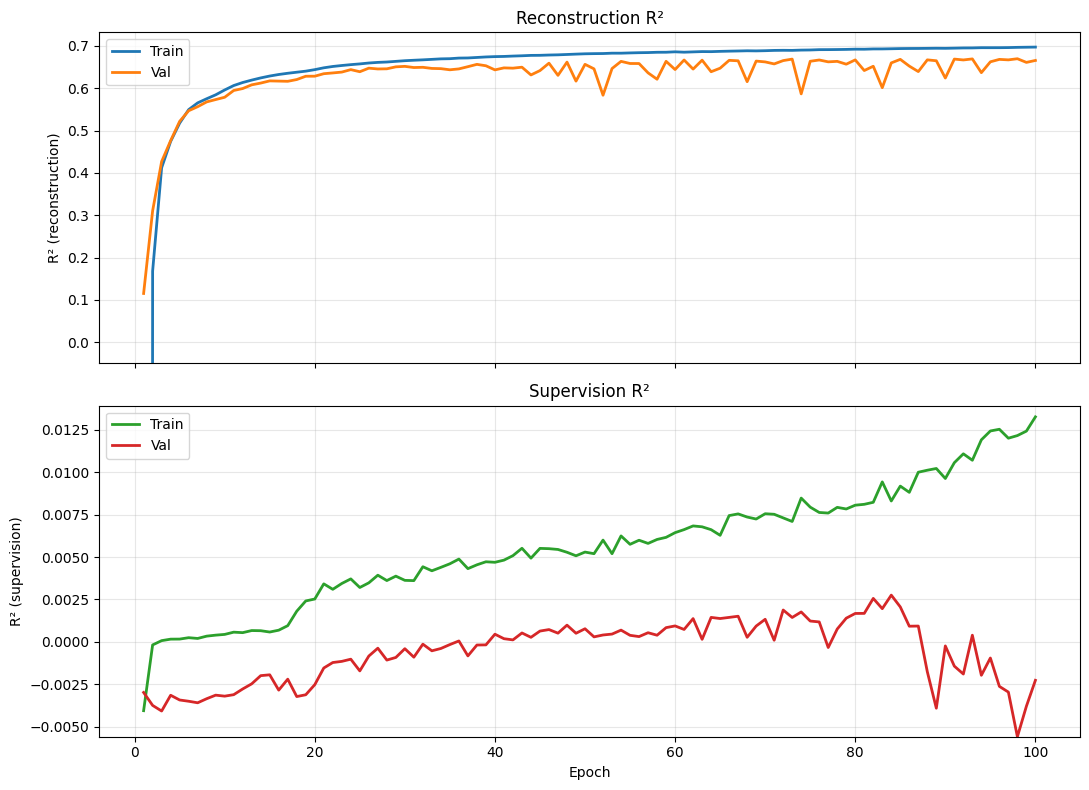


 Entraînement de l'architecture : Archi_B_L32_Large (n_latent=32)


  1%|          | 1/100 [00:11<18:28, 11.20s/it]

Epoch 01 | loss=17686.626 | R2_rec_train=-27.0013 | R2_rec_val=0.3707 | R2_sup_train=-0.0086 | R2_sup_val=-0.0014


  2%|▏         | 2/100 [00:23<19:17, 11.81s/it]

Epoch 02 | loss=407.651 | R2_rec_train=0.5058 | R2_rec_val=0.5492 | R2_sup_train=0.0007 | R2_sup_val=0.0004


  3%|▎         | 3/100 [00:34<18:14, 11.29s/it]

Epoch 03 | loss=365.321 | R2_rec_train=0.6065 | R2_rec_val=0.6133 | R2_sup_train=0.0019 | R2_sup_val=0.0021


  4%|▍         | 4/100 [00:45<18:09, 11.35s/it]

Epoch 04 | loss=345.592 | R2_rec_train=0.6563 | R2_rec_val=0.6535 | R2_sup_train=0.0035 | R2_sup_val=0.0033


  5%|▌         | 5/100 [00:57<18:27, 11.66s/it]

Epoch 05 | loss=333.761 | R2_rec_train=0.6858 | R2_rec_val=0.6742 | R2_sup_train=0.0052 | R2_sup_val=0.0049


  6%|▌         | 6/100 [01:09<18:19, 11.70s/it]

Epoch 06 | loss=324.494 | R2_rec_train=0.7073 | R2_rec_val=0.6912 | R2_sup_train=0.0077 | R2_sup_val=0.0054


  7%|▋         | 7/100 [01:21<18:22, 11.86s/it]

Epoch 07 | loss=319.213 | R2_rec_train=0.7205 | R2_rec_val=0.7045 | R2_sup_train=0.0087 | R2_sup_val=0.0041


  8%|▊         | 8/100 [01:30<16:50, 10.98s/it]

Epoch 08 | loss=314.072 | R2_rec_train=0.7349 | R2_rec_val=0.7144 | R2_sup_train=0.0100 | R2_sup_val=0.0056


  9%|▉         | 9/100 [01:43<17:19, 11.42s/it]

Epoch 09 | loss=310.159 | R2_rec_train=0.7450 | R2_rec_val=0.7175 | R2_sup_train=0.0112 | R2_sup_val=0.0050


 10%|█         | 10/100 [01:55<17:37, 11.75s/it]

Epoch 10 | loss=307.581 | R2_rec_train=0.7517 | R2_rec_val=0.7261 | R2_sup_train=0.0120 | R2_sup_val=0.0064


 11%|█         | 11/100 [02:07<17:32, 11.83s/it]

Epoch 11 | loss=305.101 | R2_rec_train=0.7584 | R2_rec_val=0.7361 | R2_sup_train=0.0132 | R2_sup_val=0.0067


 12%|█▏        | 12/100 [02:20<17:37, 12.02s/it]

Epoch 12 | loss=302.785 | R2_rec_train=0.7651 | R2_rec_val=0.7417 | R2_sup_train=0.0150 | R2_sup_val=0.0064


 13%|█▎        | 13/100 [02:34<18:14, 12.58s/it]

Epoch 13 | loss=300.216 | R2_rec_train=0.7711 | R2_rec_val=0.7439 | R2_sup_train=0.0169 | R2_sup_val=0.0069


 14%|█▍        | 14/100 [02:43<16:48, 11.72s/it]

Epoch 14 | loss=298.194 | R2_rec_train=0.7758 | R2_rec_val=0.7418 | R2_sup_train=0.0183 | R2_sup_val=0.0076


 15%|█▌        | 15/100 [02:54<16:06, 11.37s/it]

Epoch 15 | loss=296.408 | R2_rec_train=0.7799 | R2_rec_val=0.7567 | R2_sup_train=0.0200 | R2_sup_val=0.0053


 16%|█▌        | 16/100 [03:03<14:56, 10.67s/it]

Epoch 16 | loss=295.437 | R2_rec_train=0.7823 | R2_rec_val=0.7486 | R2_sup_train=0.0206 | R2_sup_val=0.0084


 17%|█▋        | 17/100 [03:12<14:06, 10.19s/it]

Epoch 17 | loss=293.860 | R2_rec_train=0.7860 | R2_rec_val=0.7648 | R2_sup_train=0.0223 | R2_sup_val=0.0066


 18%|█▊        | 18/100 [03:21<13:23,  9.80s/it]

Epoch 18 | loss=292.922 | R2_rec_train=0.7894 | R2_rec_val=0.7692 | R2_sup_train=0.0225 | R2_sup_val=0.0054


 19%|█▉        | 19/100 [03:30<12:49,  9.50s/it]

Epoch 19 | loss=291.764 | R2_rec_train=0.7927 | R2_rec_val=0.7675 | R2_sup_train=0.0239 | R2_sup_val=0.0053


 20%|██        | 20/100 [03:38<12:20,  9.26s/it]

Epoch 20 | loss=290.895 | R2_rec_train=0.7945 | R2_rec_val=0.7751 | R2_sup_train=0.0254 | R2_sup_val=0.0058


 21%|██        | 21/100 [03:50<13:00,  9.89s/it]

Epoch 21 | loss=290.248 | R2_rec_train=0.7968 | R2_rec_val=0.7733 | R2_sup_train=0.0256 | R2_sup_val=0.0037


 22%|██▏       | 22/100 [04:01<13:14, 10.19s/it]

Epoch 22 | loss=289.515 | R2_rec_train=0.7986 | R2_rec_val=0.7699 | R2_sup_train=0.0264 | R2_sup_val=0.0022


 23%|██▎       | 23/100 [04:09<12:16,  9.56s/it]

Epoch 23 | loss=288.598 | R2_rec_train=0.8008 | R2_rec_val=0.7749 | R2_sup_train=0.0272 | R2_sup_val=0.0021


 24%|██▍       | 24/100 [04:17<11:47,  9.31s/it]

Epoch 24 | loss=287.756 | R2_rec_train=0.8027 | R2_rec_val=0.7718 | R2_sup_train=0.0282 | R2_sup_val=0.0034


 25%|██▌       | 25/100 [04:26<11:16,  9.02s/it]

Epoch 25 | loss=286.914 | R2_rec_train=0.8048 | R2_rec_val=0.7728 | R2_sup_train=0.0288 | R2_sup_val=0.0034


 26%|██▌       | 26/100 [04:34<10:50,  8.79s/it]

Epoch 26 | loss=285.977 | R2_rec_train=0.8065 | R2_rec_val=0.7798 | R2_sup_train=0.0307 | R2_sup_val=0.0029


 27%|██▋       | 27/100 [04:43<10:51,  8.92s/it]

Epoch 27 | loss=285.532 | R2_rec_train=0.8080 | R2_rec_val=0.7786 | R2_sup_train=0.0307 | R2_sup_val=-0.0016


 28%|██▊       | 28/100 [04:53<11:06,  9.26s/it]

Epoch 28 | loss=284.625 | R2_rec_train=0.8096 | R2_rec_val=0.7813 | R2_sup_train=0.0328 | R2_sup_val=-0.0016


 29%|██▉       | 29/100 [05:02<10:37,  8.99s/it]

Epoch 29 | loss=283.996 | R2_rec_train=0.8113 | R2_rec_val=0.7830 | R2_sup_train=0.0335 | R2_sup_val=-0.0026


 30%|███       | 30/100 [05:10<10:15,  8.79s/it]

Epoch 30 | loss=283.361 | R2_rec_train=0.8129 | R2_rec_val=0.7887 | R2_sup_train=0.0346 | R2_sup_val=-0.0052


 31%|███       | 31/100 [05:18<09:57,  8.67s/it]

Epoch 31 | loss=282.681 | R2_rec_train=0.8147 | R2_rec_val=0.7860 | R2_sup_train=0.0354 | R2_sup_val=-0.0098


 32%|███▏      | 32/100 [05:28<10:19,  9.11s/it]

Epoch 32 | loss=282.372 | R2_rec_train=0.8163 | R2_rec_val=0.7881 | R2_sup_train=0.0352 | R2_sup_val=-0.0178


 33%|███▎      | 33/100 [05:40<10:59,  9.85s/it]

Epoch 33 | loss=281.344 | R2_rec_train=0.8181 | R2_rec_val=0.7884 | R2_sup_train=0.0375 | R2_sup_val=-0.0128


 34%|███▍      | 34/100 [05:51<11:11, 10.17s/it]

Epoch 34 | loss=280.888 | R2_rec_train=0.8202 | R2_rec_val=0.7961 | R2_sup_train=0.0373 | R2_sup_val=-0.0316


 35%|███▌      | 35/100 [06:02<11:12, 10.35s/it]

Epoch 35 | loss=279.826 | R2_rec_train=0.8224 | R2_rec_val=0.7979 | R2_sup_train=0.0394 | R2_sup_val=-0.0211


 36%|███▌      | 36/100 [06:14<11:40, 10.94s/it]

Epoch 36 | loss=279.033 | R2_rec_train=0.8245 | R2_rec_val=0.8000 | R2_sup_train=0.0405 | R2_sup_val=-0.0153


 37%|███▋      | 37/100 [06:25<11:38, 11.09s/it]

Epoch 37 | loss=278.406 | R2_rec_train=0.8267 | R2_rec_val=0.8034 | R2_sup_train=0.0410 | R2_sup_val=-0.0211


 38%|███▊      | 38/100 [06:37<11:40, 11.30s/it]

Epoch 38 | loss=277.430 | R2_rec_train=0.8285 | R2_rec_val=0.8057 | R2_sup_train=0.0430 | R2_sup_val=-0.0148


 39%|███▉      | 39/100 [06:49<11:44, 11.54s/it]

Epoch 39 | loss=276.511 | R2_rec_train=0.8307 | R2_rec_val=0.8082 | R2_sup_train=0.0442 | R2_sup_val=-0.0186


 40%|████      | 40/100 [07:00<11:17, 11.30s/it]

Epoch 40 | loss=275.892 | R2_rec_train=0.8327 | R2_rec_val=0.8075 | R2_sup_train=0.0445 | R2_sup_val=-0.0188


 41%|████      | 41/100 [07:11<10:56, 11.13s/it]

Epoch 41 | loss=275.367 | R2_rec_train=0.8343 | R2_rec_val=0.8100 | R2_sup_train=0.0449 | R2_sup_val=-0.0159


 42%|████▏     | 42/100 [07:20<10:08, 10.49s/it]

Epoch 42 | loss=274.453 | R2_rec_train=0.8359 | R2_rec_val=0.8116 | R2_sup_train=0.0469 | R2_sup_val=-0.0231


 43%|████▎     | 43/100 [07:28<09:19,  9.82s/it]

Epoch 43 | loss=273.836 | R2_rec_train=0.8372 | R2_rec_val=0.8159 | R2_sup_train=0.0478 | R2_sup_val=-0.0245


 44%|████▍     | 44/100 [07:39<09:21, 10.02s/it]

Epoch 44 | loss=273.051 | R2_rec_train=0.8387 | R2_rec_val=0.8190 | R2_sup_train=0.0494 | R2_sup_val=-0.0318


 45%|████▌     | 45/100 [07:49<09:15, 10.10s/it]

Epoch 45 | loss=272.556 | R2_rec_train=0.8398 | R2_rec_val=0.8185 | R2_sup_train=0.0501 | R2_sup_val=-0.0185


 46%|████▌     | 46/100 [08:01<09:33, 10.63s/it]

Epoch 46 | loss=271.756 | R2_rec_train=0.8409 | R2_rec_val=0.8190 | R2_sup_train=0.0520 | R2_sup_val=-0.0226


 47%|████▋     | 47/100 [08:12<09:30, 10.77s/it]

Epoch 47 | loss=271.476 | R2_rec_train=0.8418 | R2_rec_val=0.8208 | R2_sup_train=0.0521 | R2_sup_val=-0.0370


 48%|████▊     | 48/100 [08:24<09:41, 11.18s/it]

Epoch 48 | loss=270.893 | R2_rec_train=0.8425 | R2_rec_val=0.8217 | R2_sup_train=0.0535 | R2_sup_val=-0.0325


 49%|████▉     | 49/100 [08:36<09:39, 11.37s/it]

Epoch 49 | loss=270.405 | R2_rec_train=0.8434 | R2_rec_val=0.8230 | R2_sup_train=0.0543 | R2_sup_val=-0.0371


 50%|█████     | 50/100 [08:47<09:32, 11.44s/it]

Epoch 50 | loss=269.875 | R2_rec_train=0.8441 | R2_rec_val=0.8237 | R2_sup_train=0.0557 | R2_sup_val=-0.0402


 51%|█████     | 51/100 [09:00<09:37, 11.79s/it]

Epoch 51 | loss=269.302 | R2_rec_train=0.8448 | R2_rec_val=0.8264 | R2_sup_train=0.0571 | R2_sup_val=-0.0320


 52%|█████▏    | 52/100 [09:11<09:19, 11.66s/it]

Epoch 52 | loss=268.832 | R2_rec_train=0.8455 | R2_rec_val=0.8255 | R2_sup_train=0.0582 | R2_sup_val=-0.0325


 53%|█████▎    | 53/100 [09:23<09:04, 11.59s/it]

Epoch 53 | loss=268.188 | R2_rec_train=0.8461 | R2_rec_val=0.8253 | R2_sup_train=0.0601 | R2_sup_val=-0.0396


 54%|█████▍    | 54/100 [09:35<09:06, 11.88s/it]

Epoch 54 | loss=267.798 | R2_rec_train=0.8465 | R2_rec_val=0.8281 | R2_sup_train=0.0609 | R2_sup_val=-0.0343


 55%|█████▌    | 55/100 [09:47<08:50, 11.78s/it]

Epoch 55 | loss=267.300 | R2_rec_train=0.8474 | R2_rec_val=0.8304 | R2_sup_train=0.0622 | R2_sup_val=-0.0462


 56%|█████▌    | 56/100 [09:58<08:31, 11.62s/it]

Epoch 56 | loss=266.717 | R2_rec_train=0.8479 | R2_rec_val=0.8302 | R2_sup_train=0.0637 | R2_sup_val=-0.0379


 57%|█████▋    | 57/100 [10:11<08:33, 11.93s/it]

Epoch 57 | loss=266.328 | R2_rec_train=0.8486 | R2_rec_val=0.8299 | R2_sup_train=0.0646 | R2_sup_val=-0.0372


 58%|█████▊    | 58/100 [10:22<08:11, 11.71s/it]

Epoch 58 | loss=265.711 | R2_rec_train=0.8495 | R2_rec_val=0.8328 | R2_sup_train=0.0661 | R2_sup_val=-0.0424


 59%|█████▉    | 59/100 [10:34<08:00, 11.72s/it]

Epoch 59 | loss=265.392 | R2_rec_train=0.8505 | R2_rec_val=0.8334 | R2_sup_train=0.0664 | R2_sup_val=-0.0321


 60%|██████    | 60/100 [10:46<07:55, 11.89s/it]

Epoch 60 | loss=264.590 | R2_rec_train=0.8516 | R2_rec_val=0.8338 | R2_sup_train=0.0685 | R2_sup_val=-0.0458


 61%|██████    | 61/100 [10:58<07:39, 11.79s/it]

Epoch 61 | loss=264.233 | R2_rec_train=0.8524 | R2_rec_val=0.8339 | R2_sup_train=0.0693 | R2_sup_val=-0.0423


 62%|██████▏   | 62/100 [11:09<07:22, 11.66s/it]

Epoch 62 | loss=264.029 | R2_rec_train=0.8531 | R2_rec_val=0.8341 | R2_sup_train=0.0694 | R2_sup_val=-0.0407


 63%|██████▎   | 63/100 [11:22<07:25, 12.04s/it]

Epoch 63 | loss=263.293 | R2_rec_train=0.8536 | R2_rec_val=0.8362 | R2_sup_train=0.0717 | R2_sup_val=-0.0431


 64%|██████▍   | 64/100 [11:33<07:08, 11.90s/it]

Epoch 64 | loss=263.023 | R2_rec_train=0.8542 | R2_rec_val=0.8367 | R2_sup_train=0.0723 | R2_sup_val=-0.0428


 65%|██████▌   | 65/100 [11:45<06:50, 11.72s/it]

Epoch 65 | loss=262.605 | R2_rec_train=0.8546 | R2_rec_val=0.8354 | R2_sup_train=0.0736 | R2_sup_val=-0.0437


 66%|██████▌   | 66/100 [11:57<06:43, 11.87s/it]

Epoch 66 | loss=262.292 | R2_rec_train=0.8551 | R2_rec_val=0.8364 | R2_sup_train=0.0743 | R2_sup_val=-0.0510


 67%|██████▋   | 67/100 [12:08<06:27, 11.75s/it]

Epoch 67 | loss=261.841 | R2_rec_train=0.8554 | R2_rec_val=0.8380 | R2_sup_train=0.0757 | R2_sup_val=-0.0575


 68%|██████▊   | 68/100 [12:19<06:04, 11.39s/it]

Epoch 68 | loss=261.330 | R2_rec_train=0.8559 | R2_rec_val=0.8376 | R2_sup_train=0.0772 | R2_sup_val=-0.0691


 69%|██████▉   | 69/100 [12:28<05:33, 10.77s/it]

Epoch 69 | loss=261.099 | R2_rec_train=0.8563 | R2_rec_val=0.8381 | R2_sup_train=0.0777 | R2_sup_val=-0.0675


 70%|███████   | 70/100 [12:37<05:07, 10.25s/it]

Epoch 70 | loss=260.509 | R2_rec_train=0.8566 | R2_rec_val=0.8371 | R2_sup_train=0.0796 | R2_sup_val=-0.0545


 71%|███████   | 71/100 [12:46<04:42,  9.73s/it]

Epoch 71 | loss=259.838 | R2_rec_train=0.8570 | R2_rec_val=0.8385 | R2_sup_train=0.0817 | R2_sup_val=-0.0719


 72%|███████▏  | 72/100 [12:55<04:31,  9.69s/it]

Epoch 72 | loss=259.576 | R2_rec_train=0.8574 | R2_rec_val=0.8400 | R2_sup_train=0.0823 | R2_sup_val=-0.0576


 73%|███████▎  | 73/100 [13:04<04:15,  9.45s/it]

Epoch 73 | loss=259.234 | R2_rec_train=0.8579 | R2_rec_val=0.8409 | R2_sup_train=0.0830 | R2_sup_val=-0.0626


 74%|███████▍  | 74/100 [13:13<04:00,  9.26s/it]

Epoch 74 | loss=258.947 | R2_rec_train=0.8585 | R2_rec_val=0.8420 | R2_sup_train=0.0836 | R2_sup_val=-0.0655


 75%|███████▌  | 75/100 [13:24<04:04,  9.79s/it]

Epoch 75 | loss=258.545 | R2_rec_train=0.8591 | R2_rec_val=0.8421 | R2_sup_train=0.0844 | R2_sup_val=-0.0618


 76%|███████▌  | 76/100 [13:37<04:13, 10.56s/it]

Epoch 76 | loss=258.034 | R2_rec_train=0.8595 | R2_rec_val=0.8430 | R2_sup_train=0.0859 | R2_sup_val=-0.0594


 77%|███████▋  | 77/100 [13:49<04:16, 11.15s/it]

Epoch 77 | loss=257.751 | R2_rec_train=0.8599 | R2_rec_val=0.8437 | R2_sup_train=0.0865 | R2_sup_val=-0.0567


 78%|███████▊  | 78/100 [14:01<04:13, 11.52s/it]

Epoch 78 | loss=257.271 | R2_rec_train=0.8603 | R2_rec_val=0.8451 | R2_sup_train=0.0879 | R2_sup_val=-0.0685


 79%|███████▉  | 79/100 [14:13<04:01, 11.52s/it]

Epoch 79 | loss=257.155 | R2_rec_train=0.8605 | R2_rec_val=0.8438 | R2_sup_train=0.0880 | R2_sup_val=-0.0609


 80%|████████  | 80/100 [14:25<03:51, 11.59s/it]

Epoch 80 | loss=256.566 | R2_rec_train=0.8609 | R2_rec_val=0.8459 | R2_sup_train=0.0900 | R2_sup_val=-0.0696


 81%|████████  | 81/100 [14:38<03:49, 12.08s/it]

Epoch 81 | loss=256.588 | R2_rec_train=0.8612 | R2_rec_val=0.8440 | R2_sup_train=0.0895 | R2_sup_val=-0.0654


 82%|████████▏ | 82/100 [14:50<03:34, 11.94s/it]

Epoch 82 | loss=255.918 | R2_rec_train=0.8616 | R2_rec_val=0.8452 | R2_sup_train=0.0917 | R2_sup_val=-0.0614


 83%|████████▎ | 83/100 [15:01<03:19, 11.72s/it]

Epoch 83 | loss=255.933 | R2_rec_train=0.8619 | R2_rec_val=0.8452 | R2_sup_train=0.0913 | R2_sup_val=-0.0714


 84%|████████▍ | 84/100 [15:12<03:07, 11.69s/it]

Epoch 84 | loss=255.510 | R2_rec_train=0.8622 | R2_rec_val=0.8475 | R2_sup_train=0.0927 | R2_sup_val=-0.0609


 85%|████████▌ | 85/100 [15:24<02:55, 11.72s/it]

Epoch 85 | loss=255.462 | R2_rec_train=0.8624 | R2_rec_val=0.8465 | R2_sup_train=0.0926 | R2_sup_val=-0.0684


 86%|████████▌ | 86/100 [15:35<02:41, 11.57s/it]

Epoch 86 | loss=255.180 | R2_rec_train=0.8627 | R2_rec_val=0.8464 | R2_sup_train=0.0933 | R2_sup_val=-0.0569


 87%|████████▋ | 87/100 [15:46<02:26, 11.26s/it]

Epoch 87 | loss=254.382 | R2_rec_train=0.8631 | R2_rec_val=0.8476 | R2_sup_train=0.0960 | R2_sup_val=-0.0681


 88%|████████▊ | 88/100 [15:55<02:08, 10.68s/it]

Epoch 88 | loss=254.063 | R2_rec_train=0.8633 | R2_rec_val=0.8482 | R2_sup_train=0.0969 | R2_sup_val=-0.0634


 89%|████████▉ | 89/100 [16:05<01:54, 10.45s/it]

Epoch 89 | loss=254.141 | R2_rec_train=0.8636 | R2_rec_val=0.8484 | R2_sup_train=0.0964 | R2_sup_val=-0.0874


 90%|█████████ | 90/100 [16:17<01:48, 10.90s/it]

Epoch 90 | loss=253.614 | R2_rec_train=0.8639 | R2_rec_val=0.8476 | R2_sup_train=0.0981 | R2_sup_val=-0.0699


 91%|█████████ | 91/100 [16:28<01:37, 10.88s/it]

Epoch 91 | loss=253.221 | R2_rec_train=0.8643 | R2_rec_val=0.8491 | R2_sup_train=0.0990 | R2_sup_val=-0.0637


 92%|█████████▏| 92/100 [16:39<01:27, 10.95s/it]

Epoch 92 | loss=253.123 | R2_rec_train=0.8645 | R2_rec_val=0.8498 | R2_sup_train=0.0991 | R2_sup_val=-0.0787


 93%|█████████▎| 93/100 [16:52<01:20, 11.47s/it]

Epoch 93 | loss=252.776 | R2_rec_train=0.8649 | R2_rec_val=0.8496 | R2_sup_train=0.1001 | R2_sup_val=-0.0617


 94%|█████████▍| 94/100 [17:03<01:07, 11.31s/it]

Epoch 94 | loss=252.362 | R2_rec_train=0.8650 | R2_rec_val=0.8509 | R2_sup_train=0.1015 | R2_sup_val=-0.0793


 95%|█████████▌| 95/100 [17:11<00:52, 10.41s/it]

Epoch 95 | loss=252.164 | R2_rec_train=0.8653 | R2_rec_val=0.8506 | R2_sup_train=0.1020 | R2_sup_val=-0.0737


 96%|█████████▌| 96/100 [17:20<00:39, 10.00s/it]

Epoch 96 | loss=252.103 | R2_rec_train=0.8656 | R2_rec_val=0.8508 | R2_sup_train=0.1019 | R2_sup_val=-0.0677


 97%|█████████▋| 97/100 [17:30<00:29,  9.87s/it]

Epoch 97 | loss=251.776 | R2_rec_train=0.8659 | R2_rec_val=0.8509 | R2_sup_train=0.1030 | R2_sup_val=-0.0758


 98%|█████████▊| 98/100 [17:40<00:20, 10.14s/it]

Epoch 98 | loss=251.664 | R2_rec_train=0.8661 | R2_rec_val=0.8514 | R2_sup_train=0.1033 | R2_sup_val=-0.0886


 99%|█████████▉| 99/100 [17:52<00:10, 10.66s/it]

Epoch 99 | loss=251.178 | R2_rec_train=0.8664 | R2_rec_val=0.8505 | R2_sup_train=0.1048 | R2_sup_val=-0.0885


100%|██████████| 100/100 [18:04<00:00, 10.85s/it]

Epoch 100 | loss=250.916 | R2_rec_train=0.8665 | R2_rec_val=0.8520 | R2_sup_train=0.1058 | R2_sup_val=-0.0806


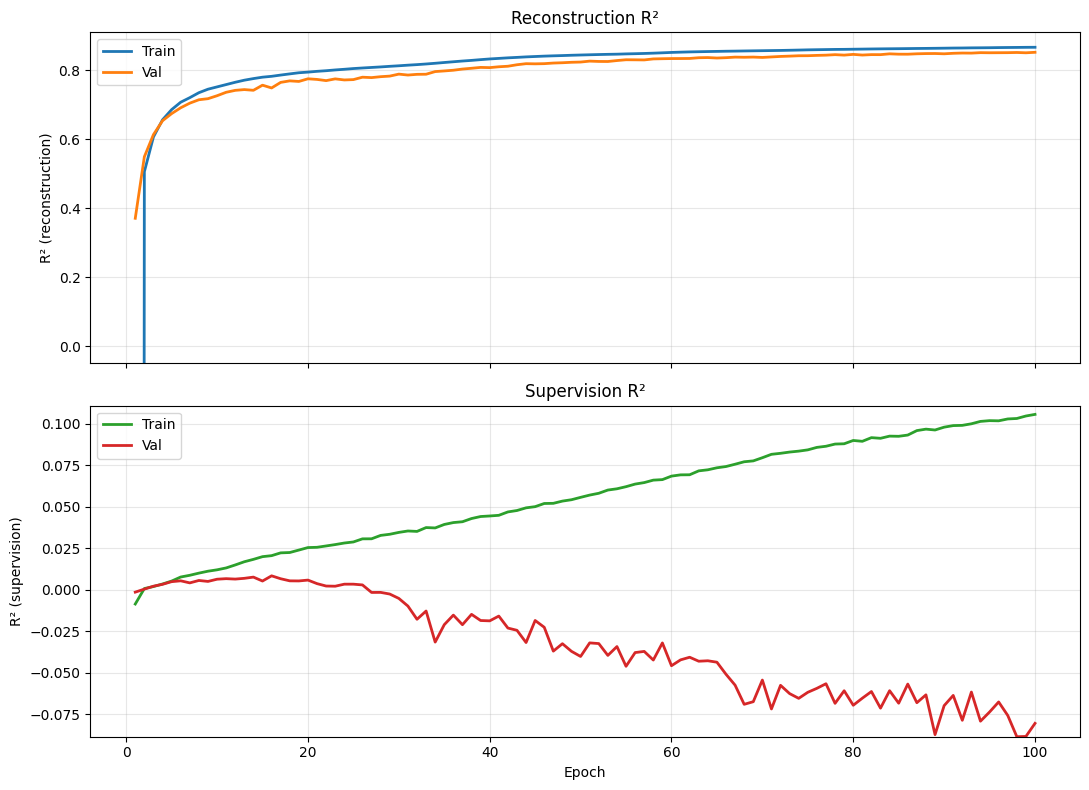


 Entraînement de l'architecture : Archi_C_L24_Hybride (n_latent=24)


  1%|          | 1/100 [00:13<21:46, 13.20s/it]

Epoch 01 | loss=13303.401 | R2_rec_train=-20.0923 | R2_rec_val=0.3276 | R2_sup_train=-0.0609 | R2_sup_val=-0.0044


  2%|▏         | 2/100 [00:26<21:35, 13.22s/it]

Epoch 02 | loss=422.441 | R2_rec_train=0.4625 | R2_rec_val=0.4889 | R2_sup_train=-0.0011 | R2_sup_val=-0.0035


  3%|▎         | 3/100 [00:39<21:21, 13.21s/it]

Epoch 03 | loss=390.752 | R2_rec_train=0.5472 | R2_rec_val=0.5622 | R2_sup_train=0.0000 | R2_sup_val=-0.0024


  4%|▍         | 4/100 [00:53<21:20, 13.34s/it]

Epoch 04 | loss=367.605 | R2_rec_train=0.6074 | R2_rec_val=0.6042 | R2_sup_train=0.0004 | R2_sup_val=-0.0033


  5%|▌         | 5/100 [01:05<20:33, 12.98s/it]

Epoch 05 | loss=353.132 | R2_rec_train=0.6444 | R2_rec_val=0.6272 | R2_sup_train=0.0007 | R2_sup_val=-0.0033


  6%|▌         | 6/100 [01:18<20:21, 12.99s/it]

Epoch 06 | loss=343.095 | R2_rec_train=0.6710 | R2_rec_val=0.6443 | R2_sup_train=0.0013 | R2_sup_val=-0.0021


  7%|▋         | 7/100 [01:31<20:16, 13.08s/it]

Epoch 07 | loss=336.101 | R2_rec_train=0.6884 | R2_rec_val=0.6639 | R2_sup_train=0.0028 | R2_sup_val=0.0002


  8%|▊         | 8/100 [01:43<19:33, 12.75s/it]

Epoch 08 | loss=330.802 | R2_rec_train=0.7011 | R2_rec_val=0.6765 | R2_sup_train=0.0047 | R2_sup_val=0.0041


  9%|▉         | 9/100 [01:56<19:05, 12.59s/it]

Epoch 09 | loss=327.106 | R2_rec_train=0.7099 | R2_rec_val=0.6763 | R2_sup_train=0.0063 | R2_sup_val=0.0019


 10%|█         | 10/100 [02:07<18:07, 12.08s/it]

Epoch 10 | loss=323.544 | R2_rec_train=0.7186 | R2_rec_val=0.6972 | R2_sup_train=0.0079 | R2_sup_val=0.0017


 11%|█         | 11/100 [02:16<16:39, 11.23s/it]

Epoch 11 | loss=320.789 | R2_rec_train=0.7256 | R2_rec_val=0.6963 | R2_sup_train=0.0092 | R2_sup_val=-0.0015


 12%|█▏        | 12/100 [02:29<17:14, 11.75s/it]

Epoch 12 | loss=318.096 | R2_rec_train=0.7318 | R2_rec_val=0.7057 | R2_sup_train=0.0112 | R2_sup_val=-0.0003


 13%|█▎        | 13/100 [02:42<17:47, 12.27s/it]

Epoch 13 | loss=316.648 | R2_rec_train=0.7357 | R2_rec_val=0.7121 | R2_sup_train=0.0125 | R2_sup_val=-0.0008


 14%|█▍        | 14/100 [02:55<17:54, 12.49s/it]

Epoch 14 | loss=314.032 | R2_rec_train=0.7423 | R2_rec_val=0.7201 | R2_sup_train=0.0140 | R2_sup_val=0.0004


 15%|█▌        | 15/100 [03:08<17:56, 12.67s/it]

Epoch 15 | loss=310.720 | R2_rec_train=0.7502 | R2_rec_val=0.7290 | R2_sup_train=0.0156 | R2_sup_val=-0.0035


 16%|█▌        | 16/100 [03:21<17:46, 12.70s/it]

Epoch 16 | loss=307.866 | R2_rec_train=0.7564 | R2_rec_val=0.7392 | R2_sup_train=0.0177 | R2_sup_val=-0.0070


 17%|█▋        | 17/100 [03:32<17:02, 12.31s/it]

Epoch 17 | loss=305.994 | R2_rec_train=0.7613 | R2_rec_val=0.7393 | R2_sup_train=0.0185 | R2_sup_val=-0.0038


 18%|█▊        | 18/100 [03:46<17:13, 12.60s/it]

Epoch 18 | loss=303.972 | R2_rec_train=0.7656 | R2_rec_val=0.7425 | R2_sup_train=0.0204 | R2_sup_val=-0.0048


 19%|█▉        | 19/100 [03:59<17:23, 12.89s/it]

Epoch 19 | loss=302.378 | R2_rec_train=0.7697 | R2_rec_val=0.7476 | R2_sup_train=0.0219 | R2_sup_val=-0.0039


 20%|██        | 20/100 [04:13<17:32, 13.15s/it]

Epoch 20 | loss=300.852 | R2_rec_train=0.7739 | R2_rec_val=0.7443 | R2_sup_train=0.0231 | R2_sup_val=-0.0033


 21%|██        | 21/100 [04:27<17:30, 13.30s/it]

Epoch 21 | loss=299.383 | R2_rec_train=0.7787 | R2_rec_val=0.7481 | R2_sup_train=0.0237 | R2_sup_val=-0.0011


 22%|██▏       | 22/100 [04:40<17:21, 13.35s/it]

Epoch 22 | loss=298.312 | R2_rec_train=0.7822 | R2_rec_val=0.7466 | R2_sup_train=0.0248 | R2_sup_val=-0.0050


 23%|██▎       | 23/100 [04:53<17:04, 13.30s/it]

Epoch 23 | loss=297.526 | R2_rec_train=0.7847 | R2_rec_val=0.7435 | R2_sup_train=0.0253 | R2_sup_val=-0.0060


 24%|██▍       | 24/100 [05:06<16:41, 13.18s/it]

Epoch 24 | loss=296.816 | R2_rec_train=0.7869 | R2_rec_val=0.7562 | R2_sup_train=0.0262 | R2_sup_val=-0.0045


 25%|██▌       | 25/100 [05:20<16:31, 13.22s/it]

Epoch 25 | loss=295.731 | R2_rec_train=0.7886 | R2_rec_val=0.7602 | R2_sup_train=0.0285 | R2_sup_val=-0.0046


 26%|██▌       | 26/100 [05:31<15:28, 12.55s/it]

Epoch 26 | loss=295.099 | R2_rec_train=0.7903 | R2_rec_val=0.7559 | R2_sup_train=0.0290 | R2_sup_val=-0.0050


 27%|██▋       | 27/100 [05:41<14:35, 11.99s/it]

Epoch 27 | loss=294.297 | R2_rec_train=0.7918 | R2_rec_val=0.7470 | R2_sup_train=0.0303 | R2_sup_val=-0.0066


 28%|██▊       | 28/100 [05:55<14:55, 12.43s/it]

Epoch 28 | loss=293.586 | R2_rec_train=0.7934 | R2_rec_val=0.7559 | R2_sup_train=0.0309 | R2_sup_val=-0.0124


 29%|██▉       | 29/100 [06:08<15:01, 12.70s/it]

Epoch 29 | loss=292.537 | R2_rec_train=0.7953 | R2_rec_val=0.7651 | R2_sup_train=0.0329 | R2_sup_val=-0.0080


 30%|███       | 30/100 [06:21<14:44, 12.64s/it]

Epoch 30 | loss=292.026 | R2_rec_train=0.7962 | R2_rec_val=0.7680 | R2_sup_train=0.0337 | R2_sup_val=-0.0102


 31%|███       | 31/100 [06:33<14:30, 12.62s/it]

Epoch 31 | loss=291.192 | R2_rec_train=0.7976 | R2_rec_val=0.7697 | R2_sup_train=0.0354 | R2_sup_val=-0.0115


 32%|███▏      | 32/100 [06:47<14:34, 12.86s/it]

Epoch 32 | loss=290.413 | R2_rec_train=0.7987 | R2_rec_val=0.7683 | R2_sup_train=0.0371 | R2_sup_val=-0.0130


 33%|███▎      | 33/100 [06:58<13:46, 12.34s/it]

Epoch 33 | loss=289.661 | R2_rec_train=0.8000 | R2_rec_val=0.7665 | R2_sup_train=0.0383 | R2_sup_val=-0.0110


 34%|███▍      | 34/100 [07:08<13:00, 11.82s/it]

Epoch 34 | loss=289.102 | R2_rec_train=0.8010 | R2_rec_val=0.7719 | R2_sup_train=0.0394 | R2_sup_val=-0.0157


 35%|███▌      | 35/100 [07:18<12:09, 11.22s/it]

Epoch 35 | loss=288.055 | R2_rec_train=0.8018 | R2_rec_val=0.7708 | R2_sup_train=0.0426 | R2_sup_val=-0.0176


 36%|███▌      | 36/100 [07:31<12:36, 11.82s/it]

Epoch 36 | loss=287.658 | R2_rec_train=0.8023 | R2_rec_val=0.7705 | R2_sup_train=0.0433 | R2_sup_val=-0.0119


 37%|███▋      | 37/100 [07:42<12:06, 11.53s/it]

Epoch 37 | loss=287.234 | R2_rec_train=0.8029 | R2_rec_val=0.7706 | R2_sup_train=0.0441 | R2_sup_val=-0.0107


 38%|███▊      | 38/100 [07:53<11:41, 11.31s/it]

Epoch 38 | loss=286.661 | R2_rec_train=0.8039 | R2_rec_val=0.7700 | R2_sup_train=0.0454 | R2_sup_val=-0.0105


 39%|███▉      | 39/100 [08:04<11:21, 11.17s/it]

Epoch 39 | loss=286.019 | R2_rec_train=0.8045 | R2_rec_val=0.7742 | R2_sup_train=0.0473 | R2_sup_val=-0.0168


 40%|████      | 40/100 [08:14<10:50, 10.84s/it]

Epoch 40 | loss=285.225 | R2_rec_train=0.8054 | R2_rec_val=0.7760 | R2_sup_train=0.0492 | R2_sup_val=-0.0124


 41%|████      | 41/100 [08:24<10:30, 10.68s/it]

Epoch 41 | loss=283.965 | R2_rec_train=0.8060 | R2_rec_val=0.7763 | R2_sup_train=0.0534 | R2_sup_val=-0.0104


 42%|████▏     | 42/100 [08:34<10:06, 10.45s/it]

Epoch 42 | loss=283.417 | R2_rec_train=0.8068 | R2_rec_val=0.7763 | R2_sup_train=0.0543 | R2_sup_val=-0.0204


 43%|████▎     | 43/100 [08:45<10:02, 10.57s/it]

Epoch 43 | loss=282.859 | R2_rec_train=0.8072 | R2_rec_val=0.7782 | R2_sup_train=0.0559 | R2_sup_val=-0.0165


 44%|████▍     | 44/100 [08:55<09:42, 10.41s/it]

Epoch 44 | loss=282.279 | R2_rec_train=0.8078 | R2_rec_val=0.7797 | R2_sup_train=0.0574 | R2_sup_val=-0.0130


 45%|████▌     | 45/100 [09:05<09:22, 10.23s/it]

Epoch 45 | loss=281.734 | R2_rec_train=0.8085 | R2_rec_val=0.7786 | R2_sup_train=0.0587 | R2_sup_val=-0.0143


 46%|████▌     | 46/100 [09:15<09:10, 10.19s/it]

Epoch 46 | loss=280.959 | R2_rec_train=0.8090 | R2_rec_val=0.7807 | R2_sup_train=0.0612 | R2_sup_val=-0.0197


 47%|████▋     | 47/100 [09:25<08:52, 10.05s/it]

Epoch 47 | loss=280.113 | R2_rec_train=0.8096 | R2_rec_val=0.7839 | R2_sup_train=0.0638 | R2_sup_val=-0.0168


 48%|████▊     | 48/100 [09:35<08:47, 10.15s/it]

Epoch 48 | loss=279.588 | R2_rec_train=0.8099 | R2_rec_val=0.7856 | R2_sup_train=0.0656 | R2_sup_val=-0.0180


 49%|████▉     | 49/100 [09:45<08:35, 10.11s/it]

Epoch 49 | loss=279.004 | R2_rec_train=0.8104 | R2_rec_val=0.7839 | R2_sup_train=0.0674 | R2_sup_val=-0.0200


 50%|█████     | 50/100 [09:55<08:27, 10.15s/it]

Epoch 50 | loss=278.641 | R2_rec_train=0.8105 | R2_rec_val=0.7824 | R2_sup_train=0.0687 | R2_sup_val=-0.0122


 51%|█████     | 51/100 [10:06<08:20, 10.21s/it]

Epoch 51 | loss=278.306 | R2_rec_train=0.8109 | R2_rec_val=0.7852 | R2_sup_train=0.0696 | R2_sup_val=-0.0147


 52%|█████▏    | 52/100 [10:16<08:14, 10.29s/it]

Epoch 52 | loss=277.216 | R2_rec_train=0.8114 | R2_rec_val=0.7857 | R2_sup_train=0.0731 | R2_sup_val=-0.0213


 53%|█████▎    | 53/100 [10:27<08:11, 10.46s/it]

Epoch 53 | loss=276.654 | R2_rec_train=0.8117 | R2_rec_val=0.7877 | R2_sup_train=0.0751 | R2_sup_val=-0.0238


 54%|█████▍    | 54/100 [10:37<07:54, 10.31s/it]

Epoch 54 | loss=276.244 | R2_rec_train=0.8121 | R2_rec_val=0.7870 | R2_sup_train=0.0763 | R2_sup_val=-0.0276


 55%|█████▌    | 55/100 [10:48<07:59, 10.66s/it]

Epoch 55 | loss=275.800 | R2_rec_train=0.8126 | R2_rec_val=0.7874 | R2_sup_train=0.0774 | R2_sup_val=-0.0204


 56%|█████▌    | 56/100 [11:02<08:30, 11.60s/it]

Epoch 56 | loss=275.048 | R2_rec_train=0.8128 | R2_rec_val=0.7887 | R2_sup_train=0.0803 | R2_sup_val=-0.0243


 57%|█████▋    | 57/100 [11:12<08:01, 11.21s/it]

Epoch 57 | loss=274.630 | R2_rec_train=0.8132 | R2_rec_val=0.7873 | R2_sup_train=0.0814 | R2_sup_val=-0.0263


 58%|█████▊    | 58/100 [11:23<07:44, 11.06s/it]

Epoch 58 | loss=274.156 | R2_rec_train=0.8135 | R2_rec_val=0.7864 | R2_sup_train=0.0830 | R2_sup_val=-0.0273


 59%|█████▉    | 59/100 [11:34<07:33, 11.05s/it]

Epoch 59 | loss=273.456 | R2_rec_train=0.8138 | R2_rec_val=0.7899 | R2_sup_train=0.0852 | R2_sup_val=-0.0376


 60%|██████    | 60/100 [11:44<07:05, 10.64s/it]

Epoch 60 | loss=272.838 | R2_rec_train=0.8142 | R2_rec_val=0.7875 | R2_sup_train=0.0874 | R2_sup_val=-0.0347


 61%|██████    | 61/100 [11:55<07:00, 10.79s/it]

Epoch 61 | loss=272.228 | R2_rec_train=0.8148 | R2_rec_val=0.7884 | R2_sup_train=0.0891 | R2_sup_val=-0.0414


 62%|██████▏   | 62/100 [12:10<07:41, 12.15s/it]

Epoch 62 | loss=271.276 | R2_rec_train=0.8151 | R2_rec_val=0.7916 | R2_sup_train=0.0922 | R2_sup_val=-0.0432


 63%|██████▎   | 63/100 [12:22<07:24, 12.00s/it]

Epoch 63 | loss=270.852 | R2_rec_train=0.8154 | R2_rec_val=0.7961 | R2_sup_train=0.0933 | R2_sup_val=-0.0388


 64%|██████▍   | 64/100 [12:32<06:54, 11.51s/it]

Epoch 64 | loss=270.477 | R2_rec_train=0.8162 | R2_rec_val=0.7939 | R2_sup_train=0.0942 | R2_sup_val=-0.0349


 65%|██████▌   | 65/100 [12:43<06:33, 11.25s/it]

Epoch 65 | loss=269.878 | R2_rec_train=0.8167 | R2_rec_val=0.7939 | R2_sup_train=0.0960 | R2_sup_val=-0.0403


 66%|██████▌   | 66/100 [12:53<06:10, 10.91s/it]

Epoch 66 | loss=269.301 | R2_rec_train=0.8170 | R2_rec_val=0.7930 | R2_sup_train=0.0979 | R2_sup_val=-0.0343


 67%|██████▋   | 67/100 [13:05<06:04, 11.05s/it]

Epoch 67 | loss=268.570 | R2_rec_train=0.8176 | R2_rec_val=0.7960 | R2_sup_train=0.1004 | R2_sup_val=-0.0330


 68%|██████▊   | 68/100 [13:18<06:14, 11.69s/it]

Epoch 68 | loss=268.158 | R2_rec_train=0.8180 | R2_rec_val=0.7934 | R2_sup_train=0.1017 | R2_sup_val=-0.0458


 69%|██████▉   | 69/100 [13:28<05:51, 11.32s/it]

Epoch 69 | loss=267.233 | R2_rec_train=0.8184 | R2_rec_val=0.7956 | R2_sup_train=0.1046 | R2_sup_val=-0.0375


 70%|███████   | 70/100 [13:39<05:33, 11.12s/it]

Epoch 70 | loss=267.510 | R2_rec_train=0.8187 | R2_rec_val=0.7922 | R2_sup_train=0.1034 | R2_sup_val=-0.0408


 71%|███████   | 71/100 [13:52<05:41, 11.78s/it]

Epoch 71 | loss=266.562 | R2_rec_train=0.8193 | R2_rec_val=0.7970 | R2_sup_train=0.1066 | R2_sup_val=-0.0409


 72%|███████▏  | 72/100 [14:02<05:15, 11.27s/it]

Epoch 72 | loss=265.839 | R2_rec_train=0.8195 | R2_rec_val=0.7962 | R2_sup_train=0.1091 | R2_sup_val=-0.0453


 73%|███████▎  | 73/100 [14:16<05:24, 12.00s/it]

Epoch 73 | loss=265.380 | R2_rec_train=0.8199 | R2_rec_val=0.7893 | R2_sup_train=0.1105 | R2_sup_val=-0.0489


 74%|███████▍  | 74/100 [14:32<05:42, 13.16s/it]

Epoch 74 | loss=264.845 | R2_rec_train=0.8201 | R2_rec_val=0.7948 | R2_sup_train=0.1122 | R2_sup_val=-0.0454


 75%|███████▌  | 75/100 [14:47<05:44, 13.77s/it]

Epoch 75 | loss=264.473 | R2_rec_train=0.8205 | R2_rec_val=0.7945 | R2_sup_train=0.1134 | R2_sup_val=-0.0489


 76%|███████▌  | 76/100 [15:01<05:34, 13.92s/it]

Epoch 76 | loss=263.627 | R2_rec_train=0.8209 | R2_rec_val=0.7937 | R2_sup_train=0.1164 | R2_sup_val=-0.0512


 77%|███████▋  | 77/100 [15:16<05:25, 14.14s/it]

Epoch 77 | loss=263.508 | R2_rec_train=0.8212 | R2_rec_val=0.7925 | R2_sup_train=0.1166 | R2_sup_val=-0.0507


 78%|███████▊  | 78/100 [15:30<05:07, 13.98s/it]

Epoch 78 | loss=262.577 | R2_rec_train=0.8216 | R2_rec_val=0.7930 | R2_sup_train=0.1199 | R2_sup_val=-0.0390


 79%|███████▉  | 79/100 [15:44<04:54, 14.02s/it]

Epoch 79 | loss=262.092 | R2_rec_train=0.8218 | R2_rec_val=0.7929 | R2_sup_train=0.1214 | R2_sup_val=-0.0518


 80%|████████  | 80/100 [16:01<04:57, 14.89s/it]

Epoch 80 | loss=261.929 | R2_rec_train=0.8222 | R2_rec_val=0.7982 | R2_sup_train=0.1219 | R2_sup_val=-0.0496


 81%|████████  | 81/100 [16:12<04:22, 13.82s/it]

Epoch 81 | loss=261.610 | R2_rec_train=0.8225 | R2_rec_val=0.7961 | R2_sup_train=0.1230 | R2_sup_val=-0.0528


 82%|████████▏ | 82/100 [16:25<04:02, 13.49s/it]

Epoch 82 | loss=260.738 | R2_rec_train=0.8227 | R2_rec_val=0.7947 | R2_sup_train=0.1263 | R2_sup_val=-0.0517


 83%|████████▎ | 83/100 [16:38<03:46, 13.32s/it]

Epoch 83 | loss=260.427 | R2_rec_train=0.8231 | R2_rec_val=0.7999 | R2_sup_train=0.1271 | R2_sup_val=-0.0579


 84%|████████▍ | 84/100 [16:51<03:35, 13.48s/it]

Epoch 84 | loss=260.045 | R2_rec_train=0.8234 | R2_rec_val=0.8008 | R2_sup_train=0.1285 | R2_sup_val=-0.0523


 85%|████████▌ | 85/100 [17:06<03:27, 13.80s/it]

Epoch 85 | loss=259.687 | R2_rec_train=0.8237 | R2_rec_val=0.7991 | R2_sup_train=0.1296 | R2_sup_val=-0.0574


 86%|████████▌ | 86/100 [17:17<03:00, 12.89s/it]

Epoch 86 | loss=259.204 | R2_rec_train=0.8239 | R2_rec_val=0.8001 | R2_sup_train=0.1313 | R2_sup_val=-0.0541


 87%|████████▋ | 87/100 [17:30<02:48, 12.93s/it]

Epoch 87 | loss=258.388 | R2_rec_train=0.8242 | R2_rec_val=0.7953 | R2_sup_train=0.1343 | R2_sup_val=-0.0573


 88%|████████▊ | 88/100 [17:44<02:41, 13.46s/it]

Epoch 88 | loss=258.244 | R2_rec_train=0.8246 | R2_rec_val=0.7981 | R2_sup_train=0.1346 | R2_sup_val=-0.0527


 89%|████████▉ | 89/100 [17:58<02:29, 13.56s/it]

Epoch 89 | loss=257.704 | R2_rec_train=0.8249 | R2_rec_val=0.7989 | R2_sup_train=0.1363 | R2_sup_val=-0.0424


 90%|█████████ | 90/100 [18:13<02:18, 13.83s/it]

Epoch 90 | loss=257.074 | R2_rec_train=0.8251 | R2_rec_val=0.8022 | R2_sup_train=0.1386 | R2_sup_val=-0.0532


 91%|█████████ | 91/100 [18:24<01:58, 13.12s/it]

Epoch 91 | loss=256.245 | R2_rec_train=0.8256 | R2_rec_val=0.7961 | R2_sup_train=0.1412 | R2_sup_val=-0.0406


 92%|█████████▏| 92/100 [18:35<01:39, 12.44s/it]

Epoch 92 | loss=255.901 | R2_rec_train=0.8259 | R2_rec_val=0.8007 | R2_sup_train=0.1424 | R2_sup_val=-0.0615


 93%|█████████▎| 93/100 [18:46<01:23, 11.88s/it]

Epoch 93 | loss=255.461 | R2_rec_train=0.8265 | R2_rec_val=0.8026 | R2_sup_train=0.1433 | R2_sup_val=-0.0438


 94%|█████████▍| 94/100 [18:56<01:08, 11.44s/it]

Epoch 94 | loss=255.171 | R2_rec_train=0.8269 | R2_rec_val=0.8013 | R2_sup_train=0.1442 | R2_sup_val=-0.0545


 95%|█████████▌| 95/100 [19:05<00:53, 10.74s/it]

Epoch 95 | loss=254.651 | R2_rec_train=0.8270 | R2_rec_val=0.8044 | R2_sup_train=0.1462 | R2_sup_val=-0.0501


 96%|█████████▌| 96/100 [19:17<00:44, 11.18s/it]

Epoch 96 | loss=254.280 | R2_rec_train=0.8272 | R2_rec_val=0.8017 | R2_sup_train=0.1475 | R2_sup_val=-0.0705


 97%|█████████▋| 97/100 [19:30<00:35, 11.73s/it]

Epoch 97 | loss=253.833 | R2_rec_train=0.8276 | R2_rec_val=0.7997 | R2_sup_train=0.1485 | R2_sup_val=-0.0454


 98%|█████████▊| 98/100 [19:43<00:23, 11.99s/it]

Epoch 98 | loss=253.035 | R2_rec_train=0.8279 | R2_rec_val=0.8029 | R2_sup_train=0.1515 | R2_sup_val=-0.0503


 99%|█████████▉| 99/100 [19:52<00:11, 11.16s/it]

Epoch 99 | loss=252.650 | R2_rec_train=0.8283 | R2_rec_val=0.8014 | R2_sup_train=0.1526 | R2_sup_val=-0.0617


100%|██████████| 100/100 [20:04<00:00, 12.05s/it]

Epoch 100 | loss=252.729 | R2_rec_train=0.8282 | R2_rec_val=0.7999 | R2_sup_train=0.1527 | R2_sup_val=-0.0535


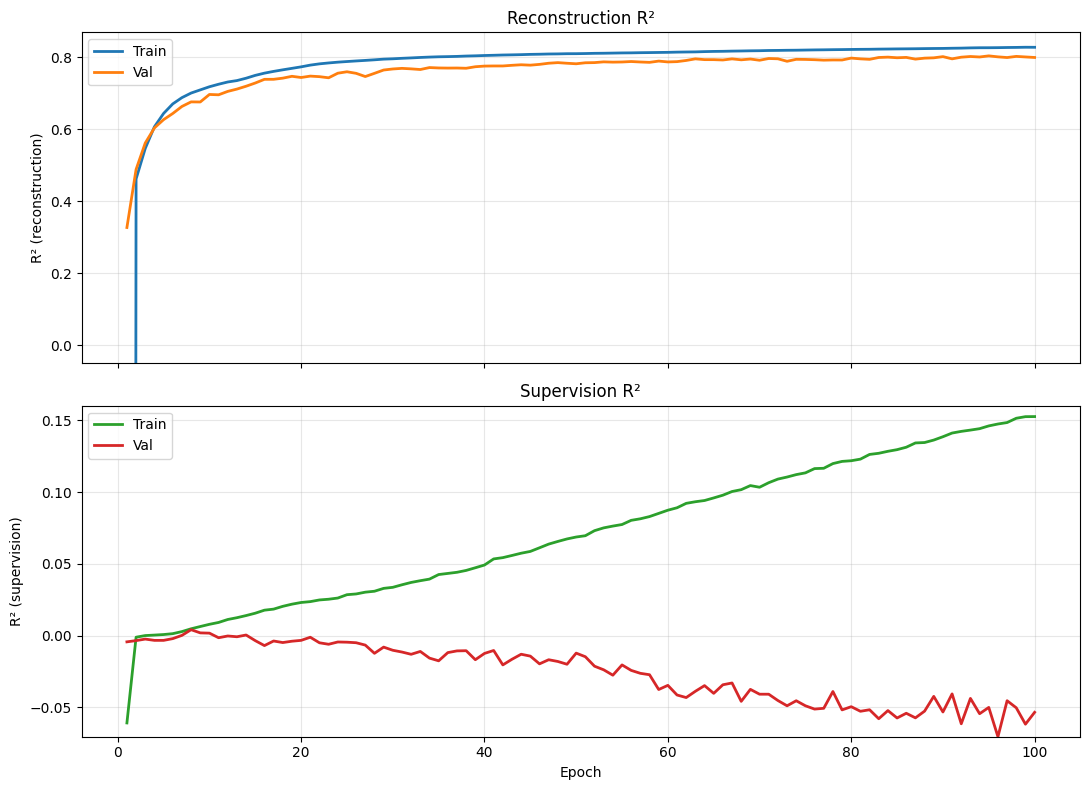

In [20]:
# Hyperparamètres fixés pour l'ensemble des tests
# Note: Ces listes doivent être assez longues pour couvrir l'architecture la plus profonde (4 couches)
activations = (nn.LeakyReLU, nn.LeakyReLU, nn.LeakyReLU)
dropout_ps = (0, 0, 0.3)  # Légère régularisation ajoutée pour les grands modèles
use_bns = (True, True, True)

# Dictionnaire pour stocker tous les résultats
all_results = {}

print("--- Lancement des entraînements par architecture et dimension latente ---")

# Boucle principale sur les architectures
for name, config in architectures_var_latent.items():
    # Extraction de la dimension latente spécifique pour ce test
    current_n_latent = config["n_latent"]
    
    print(f"\n Entraînement de l'architecture : {name} (n_latent={current_n_latent})")

    # 1. Instanciation du Modèle
    current_model = AutoEncoder(
        n_feat=n_feat,
        n_latent=current_n_latent, 
        encoder_hidden=config["encoder_hidden"],
        decoder_hidden=config["decoder_hidden"],
        head_hidden=config["head_hidden"],
        
        # Slicing des hyperparamètres pour s'adapter à la profondeur du modèle
        activations=activations[:len(config["encoder_hidden"])],
        dropout_ps=dropout_ps[:len(config["encoder_hidden"])],
        use_bns=use_bns[:len(config["encoder_hidden"])]
    )

    current_model.to(device)

    # 2. Instanciation de l'Optimiseur et du Critère
    optimizer = Adam(current_model.parameters(), lr=lr)
    criterion = CombinedLoss(alpha=alpha, beta=beta)

    # 3. Entraînement
    results = train_model(
        model=current_model,
        train_loader=train_data_loader,
        val_loader=val_data_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        n_epochs=n_epochs,
    )

    # 4. Stockage des Résultats
    all_results[name] = {
        "config": config,
        "results": results
    }


In [23]:
all_results["Archi_C_L24_Hybride"]["results"]

([-20.092334747314453,
  0.4624793827533722,
  0.5472234487533569,
  0.607384443283081,
  0.6444227695465088,
  0.6709555387496948,
  0.6883586645126343,
  0.7010862827301025,
  0.7098644375801086,
  0.718576967716217,
  0.7255810499191284,
  0.7318228483200073,
  0.7357372045516968,
  0.7423089146614075,
  0.750203013420105,
  0.7563903331756592,
  0.7612643837928772,
  0.7656081914901733,
  0.769709050655365,
  0.7738631367683411,
  0.7786868214607239,
  0.7821983695030212,
  0.7847067713737488,
  0.7868800163269043,
  0.7886275053024292,
  0.7902602553367615,
  0.7917961478233337,
  0.7934430241584778,
  0.7952951788902283,
  0.7962470054626465,
  0.7975751757621765,
  0.7987062335014343,
  0.7999649047851562,
  0.8010025024414062,
  0.8018232583999634,
  0.802291750907898,
  0.802914023399353,
  0.8039026260375977,
  0.8045364618301392,
  0.8053872585296631,
  0.8060372471809387,
  0.806773841381073,
  0.807220458984375,
  0.8077690601348877,
  0.8085356950759888,
  0.8089677095413